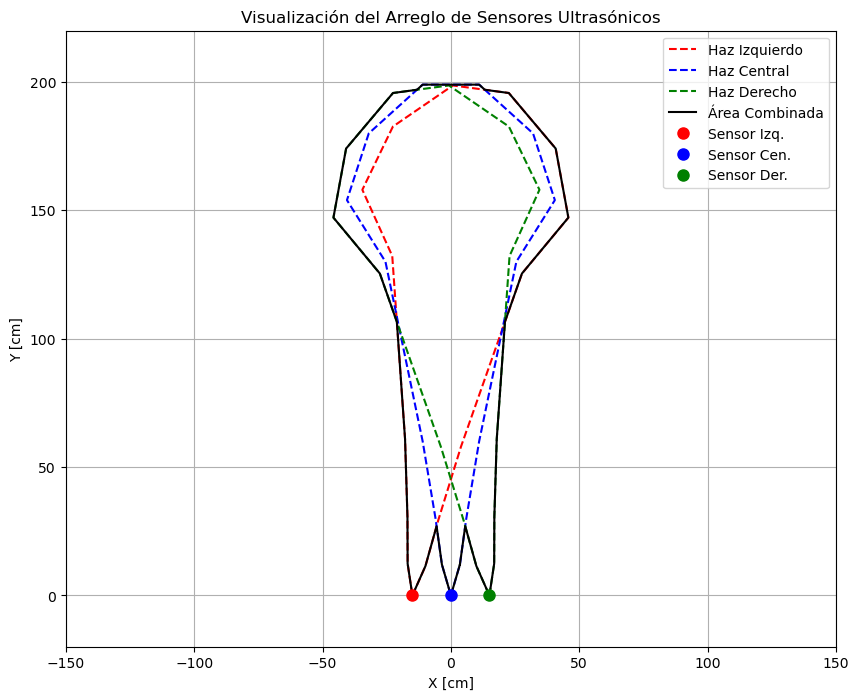

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, Point
from shapely import affinity

# --- CONFIGURACIÓN ---
# Distancia del sensor central a los sensores laterales en cm
DISTANCIA_SENSORES = 15
# Ángulo en grados que los sensores laterales se inclinan hacia el centro
ANGULO_INCLINACION = 7.7

# --- PUNTOS DIGITALIZADOS DEL HAZ DE UN SOLO SENSOR ---
# El contorno completo del lóbulo del sensor.
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]

def create_beam_geometry_from_points(shape_points, scale_factor=100.0):
    """Crea la geometría de un solo haz a partir de los puntos y la escala."""
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)

def plot_geometry(ax, geom, label, color, linestyle='--'):
    """Función auxiliar para dibujar un Polygon o MultiPolygon."""
    if geom.geom_type == 'Polygon':
        x, y = geom.exterior.xy
        ax.plot(x, y, label=label, color=color, linestyle=linestyle)
    elif geom.geom_type == 'MultiPolygon':
        for i, poly in enumerate(geom.geoms):
            x, y = poly.exterior.xy
            ax.plot(x, y, label=label if i == 0 else "", color=color, linestyle=linestyle)

# --- SCRIPT PRINCIPAL ---
fig, ax = plt.subplots(figsize=(10, 8))

# Crear el polígono base del haz en el origen (0,0)
base_beam = create_beam_geometry_from_points(SINGLE_BEAM_SHAPE_POINTS)

# --- Geometrías de los tres haces ---

# Sensor central: está en el origen (0,0) y no se rota ni traslada
g_center = base_beam

# Sensor izquierdo:
# 1. Rotarlo sobre su origen para que apunte hacia la derecha (ángulo positivo)
haz_izq_rotado = affinity.rotate(base_beam, -ANGULO_INCLINACION, origin=(0, 0))
# 2. Trasladarlo a su posición final a la izquierda del centro
g_left = affinity.translate(haz_izq_rotado, xoff=-DISTANCIA_SENSORES)

# Sensor derecho:
# 1. Rotarlo sobre su origen para que apunte hacia la izquierda (ángulo negativo)
haz_der_rotado = affinity.rotate(base_beam, ANGULO_INCLINACION, origin=(0, 0))
# 2. Trasladarlo a su posición final a la derecha del centro
g_right = affinity.translate(haz_der_rotado, xoff=DISTANCIA_SENSORES)

# Calcular el área de superposición (unión de los tres haces)
beam_area = g_center.union(g_left).union(g_right)

# --- Dibujar ---
# Dibujar los haces individuales
plot_geometry(ax, g_left, 'Haz Izquierdo', 'red', linestyle='--')
plot_geometry(ax, g_center, 'Haz Central', 'blue', linestyle='--')
plot_geometry(ax, g_right, 'Haz Derecho', 'green', linestyle='--')

# Dibujar el contorno del área combinada
plot_geometry(ax, beam_area, 'Área Combinada', 'black', linestyle='-')

# Dibujar la posición de los sensores
ax.plot(-DISTANCIA_SENSORES, 0, 'ro', markersize=8, label='Sensor Izq.')
ax.plot(0, 0, 'bo', markersize=8, label='Sensor Cen.')
ax.plot(DISTANCIA_SENSORES, 0, 'go', markersize=8, label='Sensor Der.')

# Configurar la apariencia del gráfico
ax.set_title('Visualización del Arreglo de Sensores Ultrasónicos')
ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.set_xlim([-150, 150])
ax.set_ylim([-20, 220]) # Damos un pequeño margen inferior para ver los sensores
ax.set_aspect('equal', adjustable='box')
ax.grid(True)
ax.legend()

plt.show()

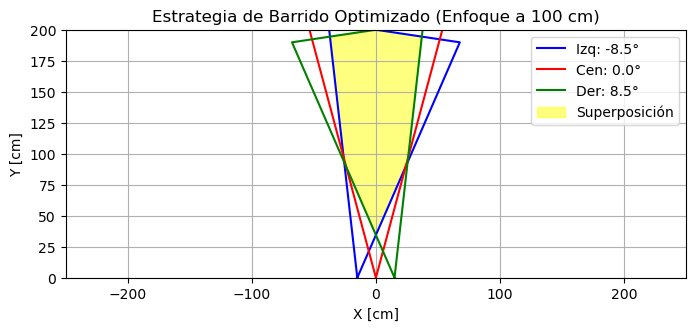

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
from shapely import affinity
import ipywidgets as widgets

# --- PARÁMETROS DE DISEÑO ---
DISTANCIA_ENTRE_SENSORES = 15  # cm (la 'd' en nuestra fórmula)
DISTANCIA_DE_ENFOQUE = 100 # cm (la 'R', distancia donde los haces convergen)
ANGULO_DEL_HAZ = 15          # Grados (la mitad del ángulo de apertura del cono de 30°)

# --- FUNCIONES DE MAPEO (CORREGIDA) ---
def obtener_angulos_optimos(theta_central_deg, d, R):
    """
    Calcula los ángulos óptimos para los sensores laterales.
    Esta versión está corregida para que los haces apunten hacia adentro.
    """
    # El ángulo 0° en robótica (hacia adelante) es 90° en matemáticas (eje Y+)
    # Sumamos 90 para convertir nuestro ángulo de barrido al sistema de coordenadas estándar
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    
    # Coordenadas del punto de enfoque (P)
    px = R * np.cos(theta_central_math_rad)
    py = R * np.sin(theta_central_math_rad)
    
    # --- Sensor Izquierdo (posición -d, 0) ---
    # Vector del sensor al punto P
    vec_x_izq = px + d
    vec_y_izq = py
    # Ángulo matemático del vector
    angulo_math_izq = np.arctan2(vec_y_izq, vec_x_izq)
    # Convertir a grados y ajustar para que 0° sea hacia adelante (restar 90°)
    angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    
    # --- Sensor Derecho (posición d, 0) ---
    vec_x_der = px - d
    vec_y_der = py
    angulo_math_der = np.arctan2(vec_y_der, vec_x_der)
    angulo_final_der = np.rad2deg(angulo_math_der) - 90
    
    return angulo_final_izq, angulo_final_der

def crear_haz_conico(distancia_max, angulo_haz_deg):
    """Crea un polígono triangular para representar un haz cónico."""
    angulo_rad = np.deg2rad(angulo_haz_deg)
    p1 = (0, 0) # El haz nace en el origen
    # El haz se define apuntando hacia arriba (eje Y)
    p2 = (distancia_max * np.tan(angulo_rad), distancia_max)
    p3 = (-distancia_max * np.tan(angulo_rad), distancia_max)
    return Polygon([p1, p2, p3])

# --- FUNCIÓN DE VISUALIZACIÓN INTERACTIVA ---
def actualizar_grafico(angulo_central):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Obtener los ángulos óptimos con la nueva función
    angulo_izq, angulo_der = obtener_angulos_optimos(angulo_central, DISTANCIA_ENTRE_SENSORES, DISTANCIA_DE_ENFOQUE)
    
    haz_base = crear_haz_conico(200, ANGULO_DEL_HAZ)
    
    # --- Geometrías ---
    # El ángulo de rotación para shapely debe ser negativo para ir a la derecha
    # y positivo para ir a la izquierda, partiendo de un haz que apunta hacia arriba.
    
    # Haz izquierdo: rotar y luego mover
    # Nota: `affinity.rotate` usa ángulos positivos para rotación antihoraria (izquierda)
    haz_izq = affinity.rotate(haz_base, angulo_izq, origin=(0, 0))
    haz_izq = affinity.translate(haz_izq, xoff=-DISTANCIA_ENTRE_SENSORES)
    
    # Haz central: solo rotar
    haz_central = affinity.rotate(haz_base, angulo_central, origin=(0, 0))
    
    # Haz derecho: rotar y luego mover
    haz_der = affinity.rotate(haz_base, angulo_der, origin=(0, 0))
    haz_der = affinity.translate(haz_der, xoff=DISTANCIA_ENTRE_SENSORES)
    
    # --- Dibujar ---
    ax.plot(*haz_izq.exterior.xy, color='blue', label=f'Izq: {angulo_izq:.1f}°')
    ax.plot(*haz_central.exterior.xy, color='red', label=f'Cen: {angulo_central:.1f}°')
    ax.plot(*haz_der.exterior.xy, color='green', label=f'Der: {angulo_der:.1f}°')
    
    superposicion = haz_central.intersection(haz_izq).intersection(haz_der)
    if not superposicion.is_empty and superposicion.geom_type == 'Polygon':
        ax.fill(*superposicion.exterior.xy, color='yellow', alpha=0.5, label='Superposición')

    ax.set_title(f"Estrategia de Barrido Optimizado (Enfoque a {DISTANCIA_DE_ENFOQUE} cm)")
    ax.set_xlabel("X [cm]"); ax.set_ylabel("Y [cm]")
    ax.set_xlim(-250, 250); ax.set_ylim(0, 200)
    ax.set_aspect('equal', adjustable='box'); ax.grid(True)
    ax.legend()
    plt.show()

actualizar_grafico(0)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, Point
from shapely import affinity
import ipywidgets as widgets
from IPython.display import display

# --- PARÁMETROS DE DISEÑO ---
DISTANCIA_ENTRE_SENSORES = 15  # cm
DISTANCIA_DE_ENFOQUE = 100 # cm (distancia donde los haces convergen)
# Ya no necesitamos ANGULO_DEL_HAZ, la forma viene de los puntos

# --- PUNTOS DIGITALIZADOS DEL HAZ DE UN SOLO SENSOR (LÓBULO) ---
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]

# --- FUNCIONES DE MAPEO (sin cambios) ---
def obtener_angulos_optimos(theta_central_deg, d, R):
    """Calcula los ángulos óptimos para los sensores laterales."""
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad)
    py = R * np.sin(theta_central_math_rad)
    
    vec_x_izq = px + d; vec_y_izq = py
    angulo_math_izq = np.arctan2(vec_y_izq, vec_x_izq)
    angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    
    vec_x_der = px - d; vec_y_der = py
    angulo_math_der = np.arctan2(vec_y_der, vec_x_der)
    angulo_final_der = np.rad2deg(angulo_math_der) - 90
    
    return angulo_final_izq, angulo_final_der

# --- NUEVA FUNCIÓN PARA CREAR EL HAZ A PARTIR DE PUNTOS ---
def create_beam_geometry_from_points(shape_points, scale_factor=100.0):
    """Crea la geometría de un solo haz a partir de los puntos y la escala."""
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)

# --- FUNCIÓN DE VISUALIZACIÓN INTERACTIVA ---
def actualizar_grafico(angulo_central, focal):
    fig, ax = plt.subplots(figsize=(8, 8))
    DISTANCIA_DE_ENFOQUE = focal
    angulo_izq, angulo_der = obtener_angulos_optimos(angulo_central, DISTANCIA_ENTRE_SENSORES, DISTANCIA_DE_ENFOQUE)
    
    # --- CAMBIO CLAVE: Usar la nueva función ---
    # En lugar de crear un cono, creamos el polígono a partir de tus puntos
    haz_base = create_beam_geometry_from_points(SINGLE_BEAM_SHAPE_POINTS)
    
    # --- Geometrías (sin cambios en la lógica de rotación/traslación) ---
    haz_izq = affinity.rotate(haz_base, angulo_izq, origin=(0, 0))
    haz_izq = affinity.translate(haz_izq, xoff=-DISTANCIA_ENTRE_SENSORES)
    
    haz_central = affinity.rotate(haz_base, angulo_central, origin=(0, 0))
    
    haz_der = affinity.rotate(haz_base, angulo_der, origin=(0, 0))
    haz_der = affinity.translate(haz_der, xoff=DISTANCIA_ENTRE_SENSORES)
    
    # --- Dibujar ---
    ax.plot(*haz_izq.exterior.xy, color='blue', label=f'Izq: {angulo_izq:.1f}°')
    ax.plot(*haz_central.exterior.xy, color='red', label=f'Cen: {angulo_central:.1f}°')
    ax.plot(*haz_der.exterior.xy, color='green', label=f'Der: {angulo_der:.1f}°')
    
    # Dibujar la superposición (solo la intersección de los tres)
    superposicion = haz_central.intersection(haz_izq).intersection(haz_der)
    if not superposicion.is_empty and superposicion.geom_type == 'Polygon':
        ax.fill(*superposicion.exterior.xy, color='yellow', alpha=0.5, label='Superposición Triple')

    # Configuración del gráfico
    ax.set_title(f"Barrido Optimizado con Lóbulo Realista (Enfoque a {DISTANCIA_DE_ENFOQUE} cm)")
    ax.set_xlabel("X [cm]"); ax.set_ylabel("Y [cm]")
    ax.set_xlim(-250, 250); ax.set_ylim(0, 220)
    ax.set_aspect('equal', adjustable='box'); ax.grid(True)
    ax.legend()
    plt.show()

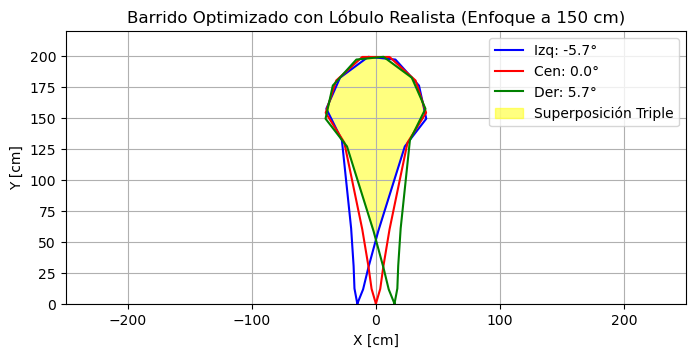

In [27]:
actualizar_grafico(0,150)

## AREA VS ANGULO

Optimizar la distancia entre sensores y la distancia de enfoque de la formula del angulo optimo de solapamiento

Calculando áreas de superposición triple para diferentes distancias de enfoque...
Cálculo para R=50 cm completado.
     70.0       |     4438.58    
     62.2       |     3803.99    
     54.4       |     3224.17    
     46.7       |     2748.00    
     38.9       |     2372.84    
     31.1       |     2082.79    
     23.3       |     1865.14    
     15.6       |     1715.52    
      7.8       |     1630.04    
      0.0       |     1602.28    
Cálculo para R=75 cm completado.
     70.0       |     5227.45    
     62.2       |     5090.43    
     54.4       |     4909.12    
     46.7       |     4711.45    
     38.9       |     4543.82    
     31.1       |     4407.33    
     23.3       |     4297.27    
     15.6       |     4220.83    
      7.8       |     4176.85    
      0.0       |     4162.51    
Cálculo para R=100 cm completado.
     70.0       |     5332.47    
     62.2       |     5322.69    
     54.4       |     5336.40    
     46.7       |     5363.41    
  

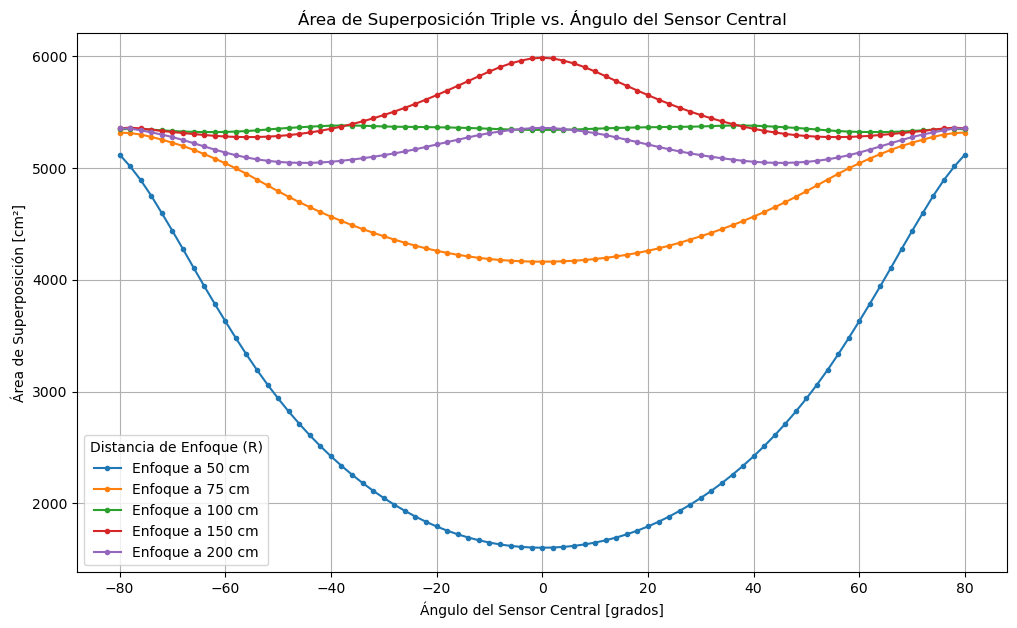

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, Point
from shapely import affinity

# --- PARÁMETROS DE DISEÑO ---
DISTANCIA_ENTRE_SENSORES = 15  # cm
# Lista de distancias de enfoque que queremos analizar
DISTANCIAS_DE_ENFOQUE = [50, 75, 100, 150, 200] # en cm

# --- PUNTOS DIGITALIZADOS DEL HAZ DE UN SOLO SENSOR (LÓBULO) ---
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]

# --- FUNCIONES DE CÁLCULO ---
def obtener_angulos_optimos(theta_central_deg, d, R):
    """Calcula los ángulos óptimos para los sensores laterales."""
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad)
    py = R * np.sin(theta_central_math_rad)
    
    vec_x_izq = px + d; vec_y_izq = py
    angulo_math_izq = np.arctan2(vec_y_izq, vec_x_izq)
    angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    
    vec_x_der = px - d; vec_y_der = py
    angulo_math_der = np.arctan2(vec_y_der, vec_x_der)
    angulo_final_der = np.rad2deg(angulo_math_der) - 90
    
    return angulo_final_izq, angulo_final_der

def create_beam_geometry_from_points(shape_points, scale_factor=100.0):
    """Crea la geometría de un solo haz a partir de los puntos y la escala."""
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)

def calcular_area_de_interseccion(theta_central_deg, distancia_enfoque):
    """
    Para un ángulo central y una distancia de enfoque dadas, calcula el área
    de la INTERSECCIÓN de los 3 haces.
    """
    angulo_izq, angulo_der = obtener_angulos_optimos(
        theta_central_deg,
        DISTANCIA_ENTRE_SENSORES,
        distancia_enfoque
    )
    
    haz_base = create_beam_geometry_from_points(SINGLE_BEAM_SHAPE_POINTS)
    
    haz_central = affinity.rotate(haz_base, theta_central_deg, origin=(0, 0))
    
    haz_izq_rotado = affinity.rotate(haz_base, angulo_izq, origin=(0, 0))
    haz_izq = affinity.translate(haz_izq_rotado, xoff=-DISTANCIA_ENTRE_SENSORES)
    
    haz_der_rotado = affinity.rotate(haz_base, angulo_der, origin=(0, 0))
    haz_der = affinity.translate(haz_der_rotado, xoff=DISTANCIA_ENTRE_SENSORES)
    
    # --- CAMBIO CLAVE: de .union() a .intersection() ---
    area_interseccion = haz_central.intersection(haz_izq).intersection(haz_der)
    
    # La intersección puede ser vacía, en cuyo caso el área es 0
    return area_interseccion.area

# --- SCRIPT PRINCIPAL ---

# 1. Definir el rango de ángulos para el barrido
angulos_barrido = np.arange(-80, 81, 2)

# Crear el gráfico
fig, ax = plt.subplots(figsize=(12, 7))

# 2. Iterar sobre cada distancia de enfoque y calcular/dibujar su curva
print("Calculando áreas de superposición triple para diferentes distancias de enfoque...")
for R in DISTANCIAS_DE_ENFOQUE:
    # Calcular las áreas para la distancia de enfoque actual
    areas_calculadas = [calcular_area_de_interseccion(angulo, R) for angulo in angulos_barrido]
    # Dibujar la curva correspondiente
    ax.plot(angulos_barrido, areas_calculadas, marker='.', linestyle='-', label=f'Enfoque a {R} cm')
    print(f"Cálculo para R={R} cm completado.")
    
    angulos_especificos = np.linspace(70, 0, 10) # 10 pasos desde 70° hasta 0°
    for angulo in angulos_especificos:
        area = calcular_area_de_interseccion(angulo, R)
        print(f"{angulo:^15.1f} | {area:^15.2f}")

# Configurar el gráfico final
ax.set_title('Área de Superposición Triple vs. Ángulo del Sensor Central')
ax.set_xlabel('Ángulo del Sensor Central [grados]')
ax.set_ylabel('Área de Superposición [cm²]')
ax.grid(True)
ax.legend(title='Distancia de Enfoque (R)')
plt.show()

## Rango de cobertura final

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, Point
from shapely import affinity

# --- PARÁMETROS DE DISEÑO FINALES ---
DISTANCIA_ENTRE_SENSORES = 15  # cm
DISTANCIA_DE_ENFOQUE = 150 # cm (tu valor óptimo)

# --- TU ESTRATEGIA DE BARRIDO ---
# Siete pasos para cubrir 140 grados, con un paso de ~23.3 grados
ANGULOS_DE_BARRIDO = [70, 46.6, 23.3, 0, -23.3, -46.6, -70]
NUMERO_DE_PASOS = 8
RANGO_DE_ANGULO = 140
PASO = RANGO_DE_ANGULO / NUMERO_DE_PASOS
ANGULOS_DE_BARRIDO = np.arange(-RANGO_DE_ANGULO/2, RANGO_DE_ANGULO/2 + PASO, PASO)

# --- PUNTOS DIGITALIZADOS DEL HAZ DE UN SOLO SENSOR (LÓBULO) ---
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]

# --- FUNCIONES DE CÁLCULO (sin cambios) ---
def obtener_angulos_optimos(theta_central_deg, d, R):
    """Calcula los ángulos óptimos para los sensores laterales."""
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad)
    py = R * np.sin(theta_central_math_rad)
    
    vec_x_izq = px + d; vec_y_izq = py
    angulo_math_izq = np.arctan2(vec_y_izq, vec_x_izq)
    angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    
    vec_x_der = px - d; vec_y_der = py
    angulo_math_der = np.arctan2(vec_y_der, vec_x_der)
    angulo_final_der = np.rad2deg(angulo_math_der) - 90
    
    return angulo_final_izq, angulo_final_der

def create_beam_geometry_from_points(shape_points, scale_factor=100.0):
    """Crea la geometría de un solo haz a partir de los puntos y la escala."""
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)

# --- SCRIPT PRINCIPAL DE VISUALIZACIÓN ---
def visualizar_barrido_completo():
    # Crear una única figura para todo el barrido
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Generar un mapa de colores para distinguir cada paso del barrido
    colors = plt.cm.get_cmap('viridis', len(ANGULOS_DE_BARRIDO))
    
    print("Calculando y dibujando las áreas de superposición para cada paso del barrido...")

    # Iterar sobre cada ángulo central de tu estrategia
    for i, angulo_central in enumerate(ANGULOS_DE_BARRIDO):
        
        angulo_izq, angulo_der = obtener_angulos_optimos(angulo_central, DISTANCIA_ENTRE_SENSORES, DISTANCIA_DE_ENFOQUE)
        
        haz_base = create_beam_geometry_from_points(SINGLE_BEAM_SHAPE_POINTS)
        
        # Geometrías de los tres haces para este paso
        haz_central = affinity.rotate(haz_base, angulo_central, origin=(0, 0))
        
        haz_izq = affinity.rotate(haz_base, angulo_izq, origin=(0, 0))
        haz_izq = affinity.translate(haz_izq, xoff=-DISTANCIA_ENTRE_SENSORES)
        
        haz_der = affinity.rotate(haz_base, angulo_der, origin=(0, 0))
        haz_der = affinity.translate(haz_der, xoff=DISTANCIA_ENTRE_SENSORES)
        
        # Calcular la superposición triple para este paso
        superposicion = haz_central.intersection(haz_izq).intersection(haz_der)
        
        # Dibujar el área de superposición con un color único y semitransparente
        if not superposicion.is_empty and superposicion.geom_type == 'Polygon':
            ax.fill(*superposicion.exterior.xy, 
                    color=colors(i), 
                    alpha=0.6, 
                    label=f'Paso a {angulo_central:.1f}°')

    # Configuración del gráfico
    ax.set_title(f"Visualización de Barrido Completo (140°) con Enfoque a {DISTANCIA_DE_ENFOQUE} cm")
    ax.set_xlabel("X [cm]")
    ax.set_ylabel("Y [cm]")
    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 220)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True)
    ax.legend(title='Ángulo Central', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout() # Ajusta el layout para que la leyenda no se corte
    plt.show()
  

/tmp/ipykernel_20933/4137348834.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(ANGULOS_DE_BARRIDO))


Calculando y dibujando las áreas de superposición para cada paso del barrido...


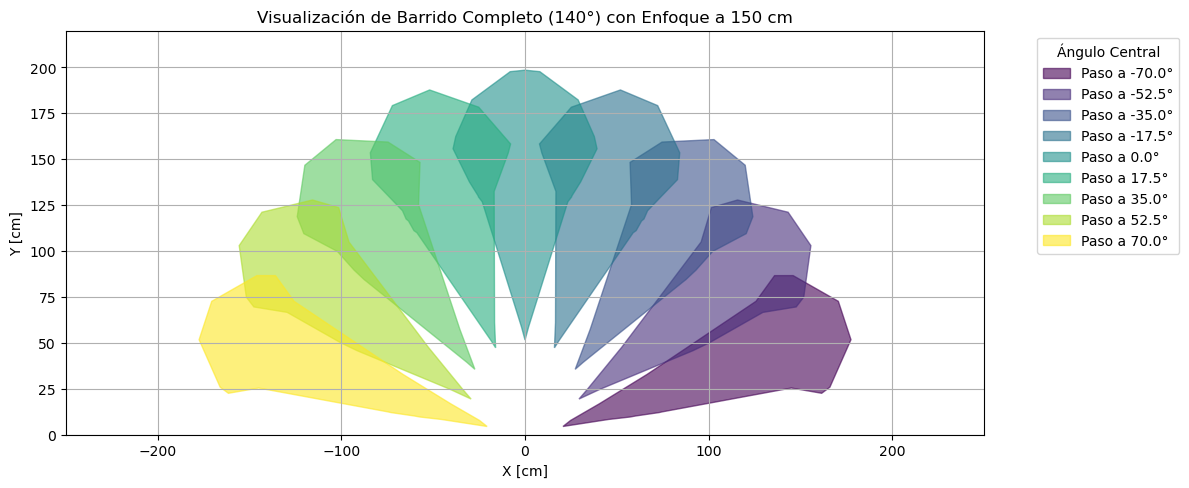

In [42]:
  visualizar_barrido_completo()

Calculando áreas de solapamiento (doble o triple) para diferentes distancias de enfoque...
Cálculo para R=50 cm completado.
Cálculo para R=75 cm completado.
Cálculo para R=100 cm completado.


/home/juan/anaconda3/envs/tfg/lib/python3.11/site-packages/shapely/set_operations.py:451: RuntimeWarning: divide by zero encountered in union
  return lib.union(a, b, **kwargs)


Cálculo para R=150 cm completado.
Cálculo para R=200 cm completado.


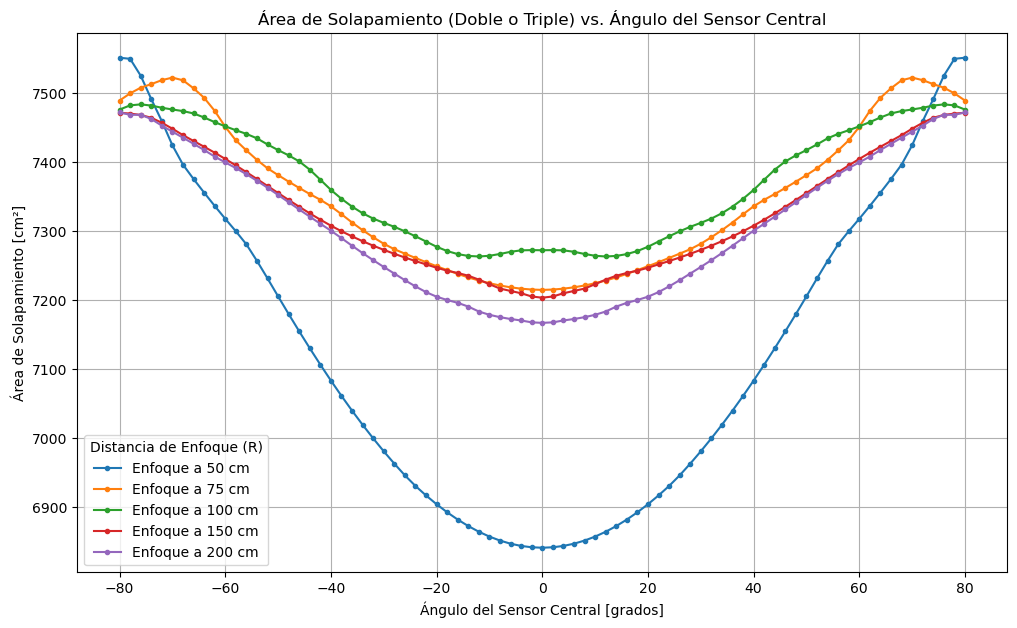

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, Point
from shapely import affinity

# --- PARÁMETROS DE DISEÑO ---
DISTANCIA_ENTRE_SENSORES = 15  # cm
DISTANCIAS_DE_ENFOQUE = [50, 75, 100, 150, 200] # en cm

# --- PUNTOS DIGITALIZADOS DEL HAZ DE UN SOLO SENSOR (LÓBULO) ---
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]

# --- FUNCIONES DE CÁLCULO ---
def obtener_angulos_optimos(theta_central_deg, d, R):
    """Calcula los ángulos óptimos para los sensores laterales."""
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad)
    py = R * np.sin(theta_central_math_rad)
    
    vec_x_izq = px + d; vec_y_izq = py
    angulo_math_izq = np.arctan2(vec_y_izq, vec_x_izq)
    angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    
    vec_x_der = px - d; vec_y_der = py
    angulo_math_der = np.arctan2(vec_y_der, vec_x_der)
    angulo_final_der = np.rad2deg(angulo_math_der) - 90
    
    return angulo_final_izq, angulo_final_der

def create_beam_geometry_from_points(shape_points, scale_factor=100.0):
    """Crea la geometría de un solo haz a partir de los puntos y la escala."""
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)

def calcular_area_de_solapamiento_doble(theta_central_deg, distancia_enfoque):
    """
    Calcula el área donde al menos DOS de los tres haces se superponen.
    """
    angulo_izq, angulo_der = obtener_angulos_optimos(
        theta_central_deg,
        DISTANCIA_ENTRE_SENSORES,
        distancia_enfoque
    )
    
    haz_base = create_beam_geometry_from_points(SINGLE_BEAM_SHAPE_POINTS)
    
    haz_central = affinity.rotate(haz_base, theta_central_deg, origin=(0, 0))
    
    haz_izq_rotado = affinity.rotate(haz_base, angulo_izq, origin=(0, 0))
    haz_izq = affinity.translate(haz_izq_rotado, xoff=-DISTANCIA_ENTRE_SENSORES)
    
    haz_der_rotado = affinity.rotate(haz_base, angulo_der, origin=(0, 0))
    haz_der = affinity.translate(haz_der_rotado, xoff=DISTANCIA_ENTRE_SENSORES)
    
    # --- CAMBIO CLAVE EN LA LÓGICA ---
    # 1. Calcular las intersecciones de cada par de haces
    interseccion_cen_izq = haz_central.intersection(haz_izq)
    interseccion_cen_der = haz_central.intersection(haz_der)
    interseccion_izq_der = haz_izq.intersection(haz_der)
    
    # 2. Unir todas las áreas de intersección para obtener la zona total de solapamiento
    area_solapamiento_total = interseccion_cen_izq.union(interseccion_cen_der).union(interseccion_izq_der)
    
    return area_solapamiento_total.area

# --- SCRIPT PRINCIPAL ---

angulos_barrido = np.arange(-80, 81, 2)
fig, ax = plt.subplots(figsize=(12, 7))

print("Calculando áreas de solapamiento (doble o triple) para diferentes distancias de enfoque...")
for R in DISTANCIAS_DE_ENFOQUE:
    areas_calculadas = [calcular_area_de_solapamiento_doble(angulo, R) for angulo in angulos_barrido]
    ax.plot(angulos_barrido, areas_calculadas, marker='.', linestyle='-', label=f'Enfoque a {R} cm')
    print(f"Cálculo para R={R} cm completado.")

# Configurar el gráfico final
ax.set_title('Área de Solapamiento (Doble o Triple) vs. Ángulo del Sensor Central')
ax.set_xlabel('Ángulo del Sensor Central [grados]')
ax.set_ylabel('Área de Solapamiento [cm²]')
ax.grid(True)
ax.legend(title='Distancia de Enfoque (R)')
plt.show()

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, Point
from shapely import affinity
import matplotlib.patches as mpatches

# --- PARÁMETROS DE DISEÑO FINALES ---
DISTANCIA_ENTRE_SENSORES = 15  # cm
DISTANCIA_DE_ENFOQUE = 150 # cm (tu valor óptimo)

# --- TU ESTRATEGIA DE BARRIDO ---
# Siete pasos para cubrir 140 grados, con un paso de ~23.3 grados
NUMERO_DE_PASOS = 8
RANGO_DE_ANGULO = 140
PASO = RANGO_DE_ANGULO / NUMERO_DE_PASOS
ANGULOS_DE_BARRIDO = np.arange(-RANGO_DE_ANGULO/2, RANGO_DE_ANGULO/2 + PASO, PASO)

# --- PUNTOS DIGITALIZADOS DEL HAZ DE UN SOLO SENSOR (LÓBULO) ---
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]

# --- FUNCIONES DE CÁLCULO ---
def obtener_angulos_optimos(theta_central_deg, d, R):
    """Calcula los ángulos óptimos para los sensores laterales."""
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad)
    py = R * np.sin(theta_central_math_rad)
    
    vec_x_izq = px + d; vec_y_izq = py
    angulo_math_izq = np.arctan2(vec_y_izq, vec_x_izq)
    angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    
    vec_x_der = px - d; vec_y_der = py
    angulo_math_der = np.arctan2(vec_y_der, vec_x_der)
    angulo_final_der = np.rad2deg(angulo_math_der) - 90
    
    return angulo_final_izq, angulo_final_der

def create_beam_geometry_from_points(shape_points, scale_factor=100.0):
    """Crea la geometría de un solo haz a partir de los puntos y la escala."""
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)

def plot_shapely_geometry(ax, geom, face_color, edge_color, alpha):
    """Función auxiliar para dibujar geometrías de shapely (Polygon y MultiPolygon)."""
    if geom.is_empty:
        return
    if geom.geom_type == 'Polygon':
        ax.fill(*geom.exterior.xy, facecolor=face_color, edgecolor=edge_color, alpha=alpha)
    elif geom.geom_type == 'MultiPolygon':
        for poly in geom.geoms:
            ax.fill(*poly.exterior.xy, facecolor=face_color, edgecolor=edge_color, alpha=alpha)

# --- SCRIPT PRINCIPAL DE VISUALIZACIÓN ---
def visualizar_barrido_comparativo():
    fig, ax = plt.subplots(figsize=(14, 9))
    
    print("Calculando y dibujando las áreas de superposición para cada paso del barrido...")

    for angulo_central in ANGULOS_DE_BARRIDO:
        
        angulo_izq, angulo_der = obtener_angulos_optimos(angulo_central, DISTANCIA_ENTRE_SENSORES, DISTANCIA_DE_ENFOQUE)
        haz_base = create_beam_geometry_from_points(SINGLE_BEAM_SHAPE_POINTS)
        
        # Geometrías de los tres haces
        haz_central = affinity.rotate(haz_base, angulo_central, origin=(0, 0))
        haz_izq = affinity.translate(affinity.rotate(haz_base, angulo_izq, origin=(0, 0)), xoff=-DISTANCIA_ENTRE_SENSORES)
        haz_der = affinity.translate(affinity.rotate(haz_base, angulo_der, origin=(0, 0)), xoff=DISTANCIA_ENTRE_SENSORES)
        
        # --- CÁLCULO DE AMBOS TIPOS DE SUPERPOSICIÓN ---
        # 1. Superposición DOBLE (o más)
        interseccion_12 = haz_central.intersection(haz_izq)
        interseccion_13 = haz_central.intersection(haz_der)
        interseccion_23 = haz_izq.intersection(haz_der)
        superposicion_doble = interseccion_12.union(interseccion_13).union(interseccion_23)
        
        # 2. Superposición TRIPLE
        superposicion_triple = interseccion_12.intersection(haz_der)
        
        # --- Dibujar ambas áreas ---
        plot_shapely_geometry(ax, superposicion_doble, 'skyblue', 'blue', 0.4)
        plot_shapely_geometry(ax, superposicion_triple, 'yellow', 'orange', 0.7)

    # Configuración del gráfico
    ax.set_title(f"Análisis Comparativo de Superposición (Enfoque a {DISTANCIA_DE_ENFOQUE} cm)")
    ax.set_xlabel("X [cm]"); ax.set_ylabel("Y [cm]")
    ax.set_xlim(-250, 250); ax.set_ylim(0, 220)
    ax.set_aspect('equal', adjustable='box'); ax.grid(True)
    
    # Crear una leyenda personalizada
    doble_patch = mpatches.Patch(color='skyblue', alpha=0.6, label='Superposición Doble (o más)')
    triple_patch = mpatches.Patch(color='yellow', alpha=0.8, label='Superposición Triple')
    ax.legend(handles=[doble_patch, triple_patch])
    
    plt.tight_layout()
    plt.show()



Calculando y dibujando las áreas de superposición para cada paso del barrido...


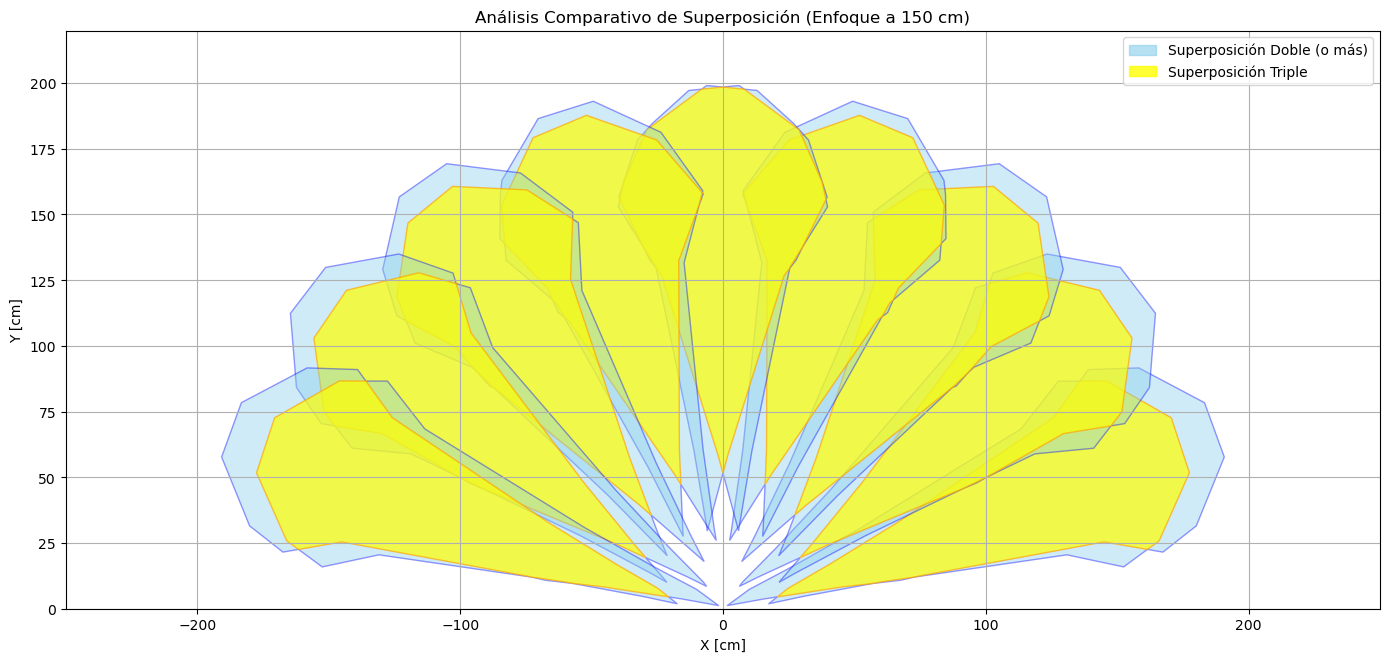

In [2]:
    visualizar_barrido_comparativo()